## Importamos las librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

## Funciones

In [2]:
def clear_outliers(data, variables):

  for i in variables:
      Q3 = np.percentile(data[i], 25, interpolation = 'midpoint')
      Q1 = np.percentile(data[i], 75, interpolation = 'midpoint')
      IQR = Q3 - Q1
      data[i] = np.where(data[i] <(Q3+1.5*IQR), (Q3+1.5*IQR),data[i])
      data[i] = np.where(data[i] >(Q1-1.5*IQR), (Q1-1.5*IQR),data[i])

  return data

In [3]:
def print_outliers(data, variables):

  for var in variables:
      sns.boxplot(data[var])
      plt.show()

In [4]:
def creacion_modelo(modelo, X, y, escalado, metrica, cm):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

  if escalado == 'MinMax':
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
  if escalado == 'scaler':
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

  model = modelo
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  train_accuracy = model.score(X_train, y_train)
  test_accuracy = model.score(X_test, y_test)

  print("Precisión en el conjunto de entrenamiento: {:.2f}".format(train_accuracy))
  print("Precisión en el conjunto de prueba: {:.2f}".format(test_accuracy))

  if metrica == 'f1':
    f1 = ((f1_score(y_test, y_pred))*100).round(2)
    print('El f1 para este modelo es {}%'.format(f1))
  if metrica == 'accuracy':
    accuracy = (accuracy_score(y_test, y_pred))*100
    print('El accuracy para este modelo es {}%'.format(accuracy.round(2)))
  if cm:
    labels = [0, 1]
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    print("Matriz de confusión:")
    print(cm)

In [5]:
def optimizacion_parametros(modelo, X, y, parametros, cv, escalado):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

  if escalado == 'MinMax':
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
  if escalado == 'scaler':
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

  LogSearch = GridSearchCV(estimator=modelo, param_grid=parametros, cv=cv)
  LogSearch.fit(X_train, y_train)

  print("Mejores hiperparámetros encontrados:")
  print(LogSearch.best_params_)

  print("Puntuación de validación cruzada media asociada a los mejores hiperparámetros:")
  print(LogSearch.best_score_)

In [6]:
def balanceo_dataset(data):
  df_0 = data[data['isFraud'] == 0]
  df_1 = data[data['isFraud'] == 1]
  size_1 = len(df_1)
  df_0_balanced = df_0.sample(n=size_1, replace=True, random_state=42)
  df_balanced = pd.concat([df_0_balanced, df_1])
  df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
  df_balanced['isFraud'].sum()
  print('Cada conjunto de datos tiene una muestra de 0 y de 1 de {}'.format(df_balanced['isFraud'].sum()))
  return df_balanced

In [7]:
def model_xgboost(modelo, X, y, cm):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  modelo = xgb.XGBClassifier()
  modelo.fit(X_train, y_train)
  y_pred = modelo.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print("El modelo presenta un accuracy de {}%".format(round((accuracy*100),2)))
  if cm:
    labels = [0, 1]
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    print("Matriz de confusión:")
    print(cm)

In [8]:
def agrupacion_tabla(var1, var2):
  tabla = data.groupby(var1)[var2].sum()
  tabla = tabla.sort_values(ascending=False)
  df_tabla = pd.DataFrame({var1: tabla.index, var2: tabla.values})
  return df_tabla

## ANALISIS EXPLORATORIO

Cargamos los datos

In [9]:
data = pd.read_csv(r'/content/drive/MyDrive/Dataset_Modeling/fraud.csv')

In [10]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Todo se encuentra en el formato adecuado

In [12]:
pd.set_option('float_format', '{:.2f}'.format)
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


Se puede ver como los valores máximos son enormes en comparación a la media por lo tanto seguramente veamos outliers. Tambien tiene pinta de estar el dataset desbalanceado. Se puede ver como isFraud y isFlaggedFraud no son iguales.

In [13]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

array([[<AxesSubplot:title={'center':'step'}>,
        <AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'oldbalanceOrg'}>],
       [<AxesSubplot:title={'center':'newbalanceOrig'}>,
        <AxesSubplot:title={'center':'oldbalanceDest'}>,
        <AxesSubplot:title={'center':'newbalanceDest'}>],
       [<AxesSubplot:title={'center':'isFraud'}>,
        <AxesSubplot:title={'center':'isFlaggedFraud'}>, <AxesSubplot:>]],
      dtype=object)

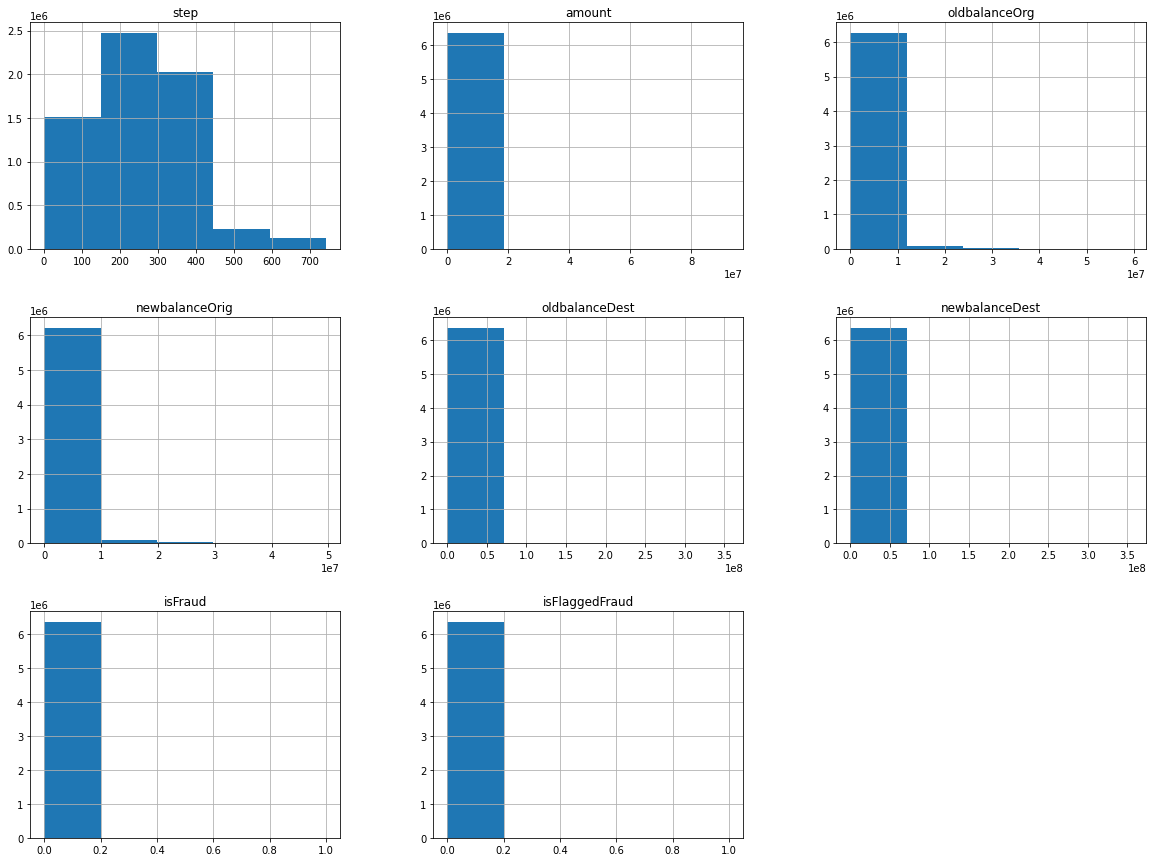

In [14]:
data.hist(bins = 5, figsize =(20,15))

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


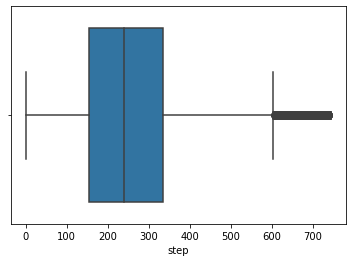

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


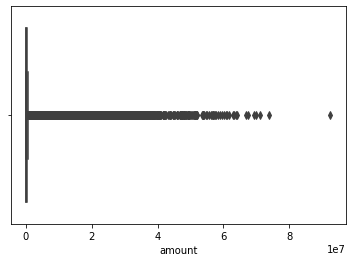

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


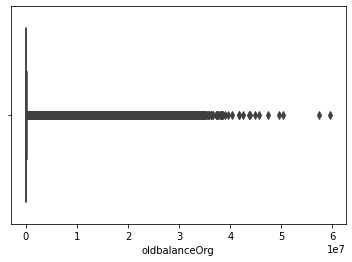

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


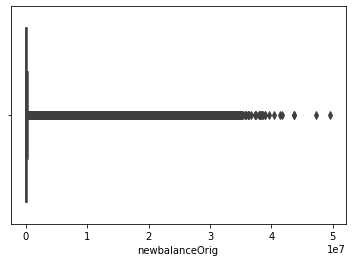

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


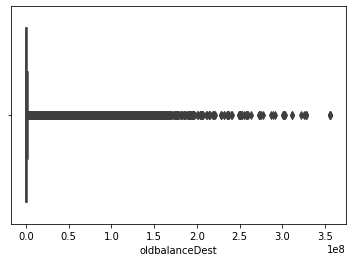

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


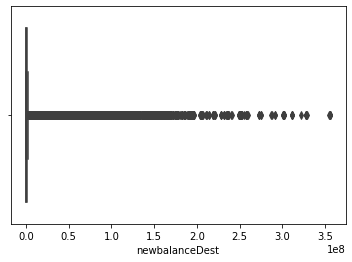

In [15]:
print_outliers(data, variables = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])

Hay una cantidad de outliers brutal que deben eliminarse para no meter ruido en el modelo y poder predecir mejor

In [16]:
clientes_orig = agrupacion_tabla('nameOrig', 'amount')
clientes_orig

,nameOrig,amount
0,C1715283297,92445516.64
1,C2127282686,73823490.36
2,C2044643633,71172480.42
3,C1425667947,69886731.30
4,C1584456031,69337316.27
...,...,...
6353302,C1294472700,0.00
6353303,C69493310,0.00
6353304,C539112012,0.00
6353305,C832555372,0.00


In [17]:
clientes_dest = agrupacion_tabla('nameDest', 'amount')
clientes_dest

,nameDest,amount
0,C439737079,357440831.44
1,C707403537,299374418.42
2,C167875008,274736432.80
3,C20253152,270116188.69
4,C172409641,255310174.25
...,...,...
2722357,M646412904,0.02
2722358,M410442874,0.02
2722359,C601248796,0.00
2722360,C1156763710,0.00


Hay muchisima diferencia entre los clientes que hace y reciben dinero frente a los que no

Filtramos los valores atipicos para eliminar outliers

In [18]:
data_filtered = clear_outliers(data, variables = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])

<ipython-input-2-1e0b1dfc75fc>:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q3 = np.percentile(data[i], 25, interpolation = 'midpoint')
<ipython-input-2-1e0b1dfc75fc>:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q1 = np.percentile(data[i], 75, interpolation = 'midpoint')


array([[<AxesSubplot:title={'center':'step'}>,
        <AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'oldbalanceOrg'}>],
       [<AxesSubplot:title={'center':'newbalanceOrig'}>,
        <AxesSubplot:title={'center':'oldbalanceDest'}>,
        <AxesSubplot:title={'center':'newbalanceDest'}>],
       [<AxesSubplot:title={'center':'isFraud'}>,
        <AxesSubplot:title={'center':'isFlaggedFraud'}>, <AxesSubplot:>]],
      dtype=object)

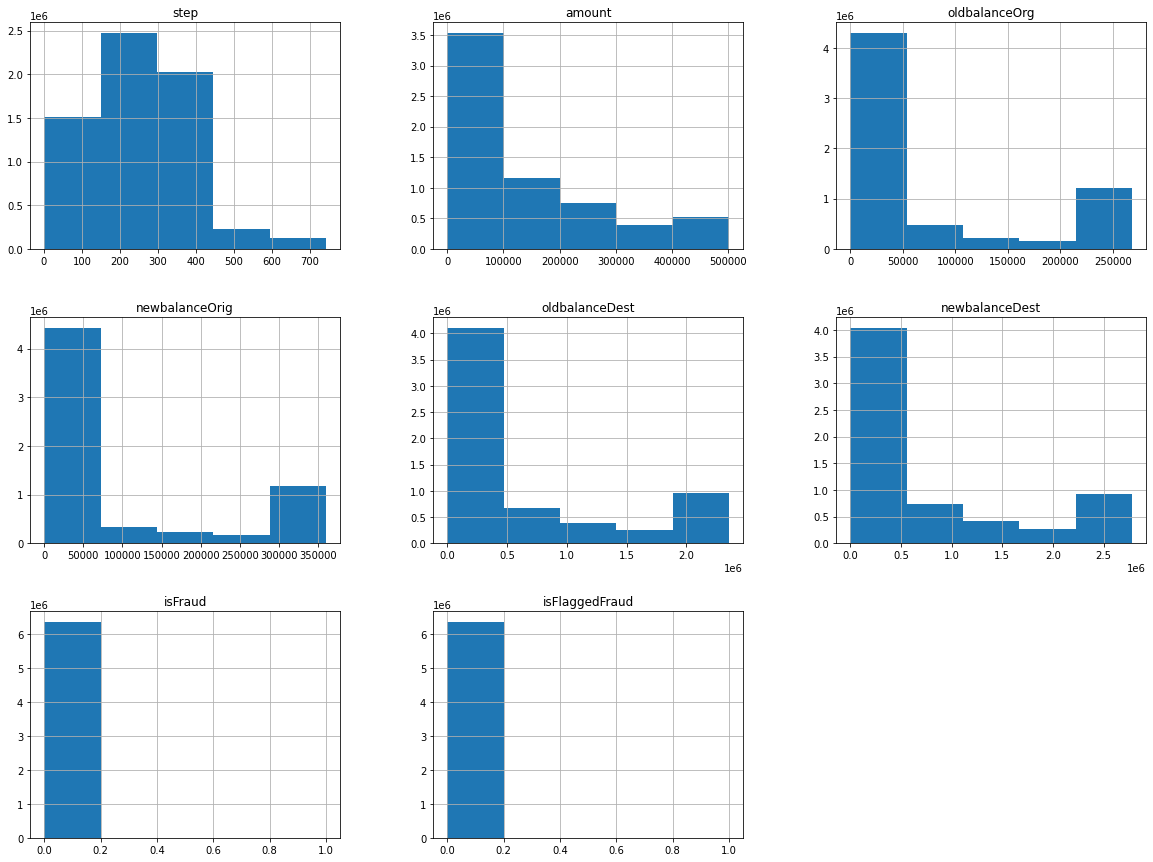

In [19]:
data_filtered.hist(bins = 5, figsize =(20,15))

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


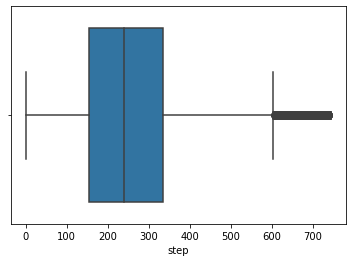

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


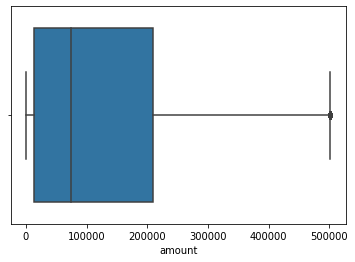

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


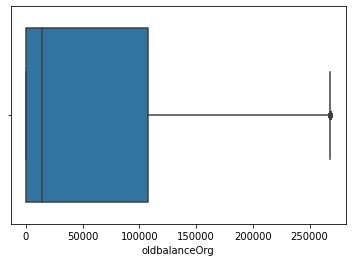

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


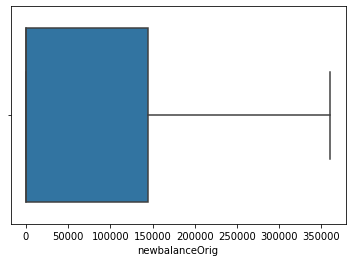

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


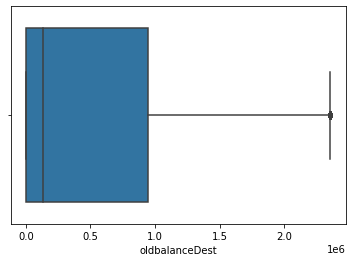

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


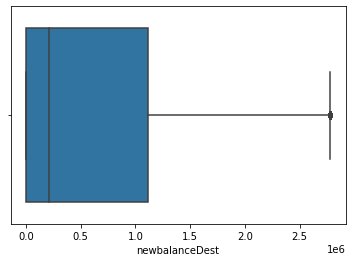

In [20]:
print_outliers(data_filtered, variables = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])

Sigue habiendo outliers pero no es tan notorio.

In [21]:
data_filtered['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [22]:
data_filtered.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [23]:
print(data.groupby('type')['isFraud'].sum())

type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64


Vamos a ver el número en % del fraude que corresponde a esa categoria

In [24]:
#Para la categoria CASH_OUT
((data.groupby('type')['isFraud'].sum()[1])*100)/(data_filtered.type.value_counts()[0])

0.18395530726256984

In [25]:
#Para la categoria TRANSFER
((data.groupby('type')['isFraud'].sum()[4])*100)/(data_filtered.type.value_counts()[3])

0.7687991758442811

Esto es raro, solo hay fraude en dos tipos de transacciones. De todas maneras, el % que supone para cada categoria es infimo

In [26]:
data_filtered.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

Vemos que el fraude se encuentra agrupado en dos categorias y claramente desbalanceado

In [27]:
data_filtered['isFlaggedFraud'].sum()

16

Parece que no aporta ningun valor, ni que este relacionada con isFraud

In [28]:
data_filtered['isFraud'].sum()

8213

In [29]:
data_dummies = pd.get_dummies(data_filtered['type'], drop_first=True)
data_dummies = pd.concat([data, data_dummies], axis=1)
data_dummies = data_dummies.drop(['type', 'isFlaggedFraud'], axis = 1)

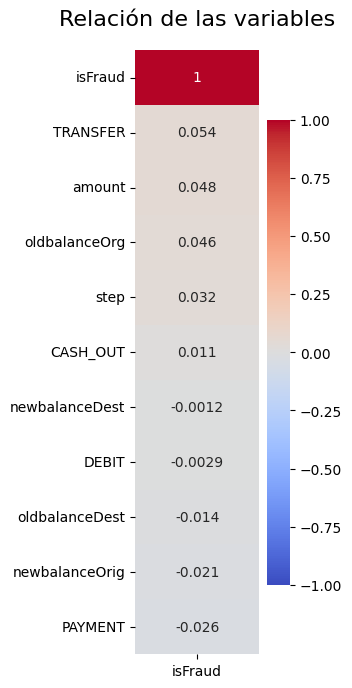

In [30]:
plt.figure (figsize = (2 , 8) , dpi = 100)
heatmap = sns.heatmap (data_dummies.corr()[['isFraud']].sort_values (by = 'isFraud', ascending = False), vmin = -1, vmax = 1, annot = True, cmap = 'coolwarm')
heatmap.set_title ('Relación de las variables', fontdict = {'fontsize':16} , pad = 18);

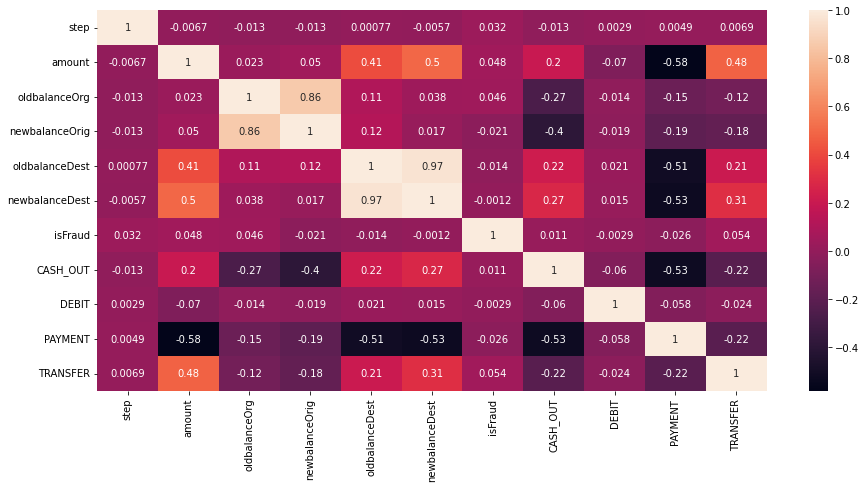

In [31]:
corr_data_model = data_dummies.corr ()
plt.figure(figsize=(15, 7))
sns.heatmap(corr_data_model, annot=True)
plt.show()

Eliminaremos varibales oldbalanceOrg y oldbalanceDest para evitar multicolinealidad

In [32]:
data_dummies['isFraud'].sum()

8213

In [33]:
print(((data_dummies['isFraud'].sum()/data_dummies.shape[0]))*100)

0.12908204481801522


Existe un gran debalanceo entre la clase 0 y 1 en la variable fraude, no llegando al 1% por lo tanto vamos a balancear el dataset

In [34]:
df_balanced = balanceo_dataset(data_dummies)

Cada conjunto de datos tiene una muestra de 0 y de 1 de 8213


In [35]:
df_balanced.shape

(16426, 13)

## MODELIZACIÓN

Separación del dato 

In [36]:
X_balanceado = df_balanced[['step', 'amount', 'newbalanceOrig', 'newbalanceDest', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']]
y_balanceado = df_balanced['isFraud']

ARBOL DE DECISION

In [37]:
parametros = {'criterion' :['entropy', 'gini'], 'max_depth' : [1,2,3,4], 'random_state' : [42]}
optimizacion_parametros(DecisionTreeClassifier(), X_balanceado, y_balanceado, parametros, 10, 'MinMax')

Mejores hiperparámetros encontrados:
{'criterion': 'gini', 'max_depth': 4, 'random_state': 42}
Puntuación de validación cruzada media asociada a los mejores hiperparámetros:
0.8515981735159818


In [38]:
creacion_modelo(DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, random_state = 42), X_balanceado, y_balanceado, 'MinMax', 'accuracy', True)

Precisión en el conjunto de entrenamiento: 0.85
Precisión en el conjunto de prueba: 0.86
El accuracy para este modelo es 85.54%
Matriz de confusión:
[[1625   34]
 [ 441 1186]]


RANDOM FOREST CLASSIFIER

In [39]:
parametros = {'max_depth': [2,5,10],'min_samples_split': [1,2,3],'max_features': ['sqrt', None],'criterion': ['gini', 'entropy']}
optimizacion_parametros(RandomForestClassifier(), X_balanceado, y_balanceado, parametros, 5, 'MinMax')

Mejores hiperparámetros encontrados:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 1}
Puntuación de validación cruzada media asociada a los mejores hiperparámetros:
0.9286149162861491


In [40]:
creacion_modelo(RandomForestClassifier(n_estimators=100, max_depth=10, criterion = 'entropy', max_features = None, min_samples_split = 2), X_balanceado, y_balanceado, 'MinMax', 'accuracy', True)

Precisión en el conjunto de entrenamiento: 0.93
Precisión en el conjunto de prueba: 0.93
El accuracy para este modelo es 93.43%
Matriz de confusión:
[[1590   69]
 [ 147 1480]]


XGBoost

Para el XGBoost no vamos a eliminar outliers ya que puede ser contraproducente para este tipo de modelos

In [41]:
data_dummies_outliers = pd.get_dummies(data['type'], drop_first=True)
data_dummies_outliers = pd.concat([data, data_dummies_outliers], axis=1)
data_dummies_outliers = data_dummies_outliers.drop(['type', 'isFlaggedFraud'], axis = 1)

In [42]:
df_balanced_outliers = balanceo_dataset(data_dummies_outliers)

Cada conjunto de datos tiene una muestra de 0 y de 1 de 8213


In [43]:
X_outliers = df_balanced_outliers[['step', 'amount', 'newbalanceOrig', 'newbalanceDest', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']]
y_outliers = df_balanced_outliers['isFraud']

In [44]:
model_xgboost(xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.5, colsample_bytree=0.5, random_state=42), X_outliers, y_outliers, True)

El modelo presenta un accuracy de 93.91%
Matriz de confusión:
[[1580   84]
 [ 116 1506]]
